In [19]:
# train_detector.py
import json
from pathlib import Path
import torch
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# ─── CONFIG ────────────────────────────────────────────────────────────────────
PATCHES_DIR   = Path(r"C:\Users\lisan\AIMI_PROJECT\patches\cpg")
JSON_DIR      = Path(r"C:\Users\lisan\monkey-data\annotations\json_mm")
OUTPUT_JSON   = Path(r"C:\Users\lisan\AIMI_PROJECT\patches\submission.json")

PATCH_SIZE    = 256        # as in your extract_patch call
BBOX_SIZE     = 32         # size of the box we teach the model to find
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES   = 2          # background + inflammatory
LR            = 1e-4
EPOCHS        = 12
BATCH_SIZE    = 4
PATIENCE       = 3       # early stop if no val recall improvement

SCORE_THR     = 0.5

# ── TRANSFORMS ────────────────────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
# ─── HELPERS ───────────────────────────────────────────────────────────────────
def parse_slide_jsons(json_dir):
    """
    Return dict mapping (slide_id, class_name) -> list of (x,y) ROI coords (pixels).
    """
    d = {}
    for jf in json_dir.glob("A_*_*.json"):
        parts = jf.stem.split("_")        # ["A","P000001","inflammatory-cells"]
        slide = parts[1]
        cls   = "_".join(parts[2:])
        data  = json.loads(jf.read_text())
        pts   = [pt["point"] for pt in data["points"]]
        d[(slide, cls)] = pts
    return d

def build_patch_annotations(patches_dir: Path, coords_dict: dict) -> dict:
    """
    For each patch image under patches_dir/<class>/*.png:
      - We ignore the JSON indexing entirely
      - We place exactly one BBOX_SIZE×BBOX_SIZE box centered in the PATCH_SIZE×PATCH_SIZE patch
    """
    annots = {}
    half = PATCH_SIZE // 2
    off  = half - BBOX_SIZE // 2

    for img_path in patches_dir.glob("*/*.png"):
        name = img_path.name  # e.g. "P000009_inflammatory-cells_patch0.png"

        # simply assign a centred box for every patch
        x1 = off
        y1 = off
        x2 = off + BBOX_SIZE
        y2 = off + BBOX_SIZE
        annots[name] = [[x1, y1, x2, y2]]

    return annots

# ─── DATASET ────────────────────────────────────────────────────────────────────
class PatchDetectDataset(Dataset):
    def __init__(self, patches_dir, annots, transform=None):
        """
        patches_dir: parent folder containing subfolders per class
        annots:      dict patch_filename -> list of [x1,y1,x2,y2]
        """
        self.annots  = annots
        self.transform = transform
        # list of all patch filenames
        self.names = list(annots.keys())
        self.pd    = patches_dir

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        # find the image file under any class subfolder
        img_paths = list(self.pd.glob(f"*/*{name}"))
        if not img_paths:
            raise FileNotFoundError(f"Could not find patch {name}")
        img = Image.open(img_paths[0]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        # build target
        boxes  = torch.tensor(self.annots[name], dtype=torch.float32)
        labels = torch.ones((boxes.size(0),), dtype=torch.int64)  # all class=1
        target = {"boxes": boxes, "labels": labels}
        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))


In [20]:
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


coords_dict = parse_slide_jsons(JSON_DIR)

    # 2) Build per-patch annotation dict
patch_annots = build_patch_annotations(PATCHES_DIR, coords_dict)

    # 3) Create Dataset & DataLoader
tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ])
ds = PatchDetectDataset(PATCHES_DIR, patch_annots, transform=tf)
#dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True,
#                    collate_fn=collate_fn, num_workers=2)
dl = DataLoader(
    ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,    # ← no subprocesses
)

    # 4) Set up Faster R‑CNN
sizes = ((16,32,64),)*5
ratios= ((1.0,),)*5
anchor_gen = AnchorGenerator(sizes=sizes, aspect_ratios=ratios)

# 2) build model
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn(weights=weights,
                                    rpn_anchor_generator=anchor_gen)
#swap heads
in_feats = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, NUM_CLASSES)
model.to(DEVICE)

opt = optim.Adam(model.parameters(), lr=LR)

    # 5) Train
for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0
        for imgs, targets in tqdm(dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            imgs   = [i.to(DEVICE) for i in imgs]
            tgts   = [{k:v.to(DEVICE) for k,v in t.items()} for t in targets]
            loss_dict = model(imgs, tgts)
            loss = sum(loss_dict.values())

            opt.zero_grad()
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} avg loss: {epoch_loss/len(dl):.4f}")
torch.save(model.state_dict(), "fasterrcnn_finetuned_12.pth")

PATCHES_DIR = Path(r"C:\Users\lisan\AIMI_PROJECT\patches")
CPG_DIR     = PATCHES_DIR / "cpg"

# collect every .png file under each class folder
all_patches = []
for cls in ["inflammatory-cells", "monocytes", "lymphocytes"]:
    class_folder = CPG_DIR / cls
    all_patches.extend(class_folder.glob("*.png"))

# ─── AFTER TRAINING, INFERENCE & COLLECT PIXEL COORDS ────────────────────────
model.eval()
SCORE_THRESH = 0.5

# collect all your patches as before
PATCHES_DIR = Path(r"C:\Users\lisan\AIMI_PROJECT\patches")
CPG_DIR     = PATCHES_DIR / "cpg"
all_patches = []
for cls in ["inflammatory-cells", "monocytes", "lymphocytes"]:
    all_patches += list((CPG_DIR/cls).glob("*.png"))

results = {}  # will map: filename → list of (x1,y1,x2,y2,score)
with torch.no_grad():
    for img_path in all_patches:
        # load & preprocess
        img_orig = Image.open(img_path).convert("RGB")
        inp = transform(img_orig).to(DEVICE)

        # forward
        out = model([inp])[0]
        boxes  = out["boxes"].cpu().tolist()
        scores = out["scores"].cpu().tolist()

        # filter low‐confidence
        keep = [i for i,s in enumerate(scores) if s>=SCORE_THRESH]
        detections = []
        for i in keep:
            x1,y1,x2,y2 = boxes[i]
            sc = scores[i]
            detections.append((x1,y1,x2,y2,sc))

        # store
        results[img_path.name] = detections

# now `results` holds all the  pixel coordinates + scores


Epoch 1/12: 100%|██████████| 98/98 [40:10<00:00, 24.59s/it]


Epoch 1 avg loss: 0.6251


Epoch 2/12: 100%|██████████| 98/98 [28:09<00:00, 17.24s/it]


Epoch 2 avg loss: 0.5736


Epoch 3/12: 100%|██████████| 98/98 [28:47<00:00, 17.63s/it]


Epoch 3 avg loss: 0.4285


Epoch 4/12: 100%|██████████| 98/98 [28:29<00:00, 17.44s/it]


Epoch 4 avg loss: 0.6017


Epoch 5/12: 100%|██████████| 98/98 [27:55<00:00, 17.09s/it]


Epoch 5 avg loss: 0.4295


Epoch 6/12: 100%|██████████| 98/98 [29:17<00:00, 17.94s/it]


Epoch 6 avg loss: 0.3784


Epoch 7/12: 100%|██████████| 98/98 [31:00<00:00, 18.99s/it]


Epoch 7 avg loss: 0.3363


Epoch 8/12: 100%|██████████| 98/98 [29:12<00:00, 17.88s/it]


Epoch 8 avg loss: 0.2887


Epoch 9/12: 100%|██████████| 98/98 [28:37<00:00, 17.52s/it]


Epoch 9 avg loss: 2.1519


Epoch 10/12: 100%|██████████| 98/98 [28:04<00:00, 17.19s/it]


Epoch 10 avg loss: 0.5592


Epoch 11/12: 100%|██████████| 98/98 [28:10<00:00, 17.25s/it]


Epoch 11 avg loss: 0.4966


Epoch 12/12: 100%|██████████| 98/98 [28:06<00:00, 17.21s/it]


Epoch 12 avg loss: 0.4638


In [21]:
#print out all the coordinates.

#for fn, dets in results.items():
#    print(f"\n{fn}:")
#    for x1,y1,x2,y2,sc in dets:
#        print(f"  box=({x1:.1f},{y1:.1f}->{x2:.1f},{y2:.1f}), score={sc:.2f}")

In [22]:
## This  is where the results get put in SO CHANGE THE NAME WITH NR EPOCHS
import json
from pathlib import Path

OUT_JSON = Path("detection_results_12.json")

# 1) Write to disk
with OUT_JSON.open("w") as f:
    json.dump(results, f, indent=2)

print(f"Wrote {len(results)} entries to {OUT_JSON!r}")


Wrote 390 entries to WindowsPath('detection_results_12.json')


In [23]:
# — later, to load it back in another script or notebook —

# with OUT_JSON.open("r") as f:
#    loaded_results = json.load(f)

# Now loaded_results == results

In [24]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
from PIL import Image

def visualize_patch_grid(results, patches_dir, class_folders, patch_list, cols=3, figsize=(12,8), score_thresh=0.5):
    """
    results:      dict mapping filename -> list of (x1,y1,x2,y2,score)
    patches_dir:  Path to parent of class subfolders (e.g. .../cpg)
    class_folders: list of your subfolder names, e.g. ["inflammatory-cells", "monocytes", "lymphocytes"]
    patch_list:   list of filenames you want to plot, e.g. ["P000026_monocytes_patch0.png", ...]
    cols:         how many columns in the grid
    """
    rows = math.ceil(len(patch_list)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for ax, fname in zip(axes, patch_list):
        # locate the file under one of the class folders
        img_path = None
        for cls in class_folders:
            p = patches_dir/cls/fname
            if p.exists():
                img_path = p
                break
        if img_path is None:
            raise FileNotFoundError(f"Couldn’t find {fname} in any subfolder of {patches_dir}")

        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(fname, fontsize=9)
        ax.axis("off")

        # draw each box above the threshold
        for (x1,y1,x2,y2,sc) in results.get(fname, []):
            if sc < score_thresh:
                continue
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-3, f"{sc:.2f}",
                    color='yellow', fontsize=7,
                    bbox=dict(facecolor='black', alpha=0.6, pad=1))

    # turn off any unused axes
    for ax in axes[len(patch_list):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()


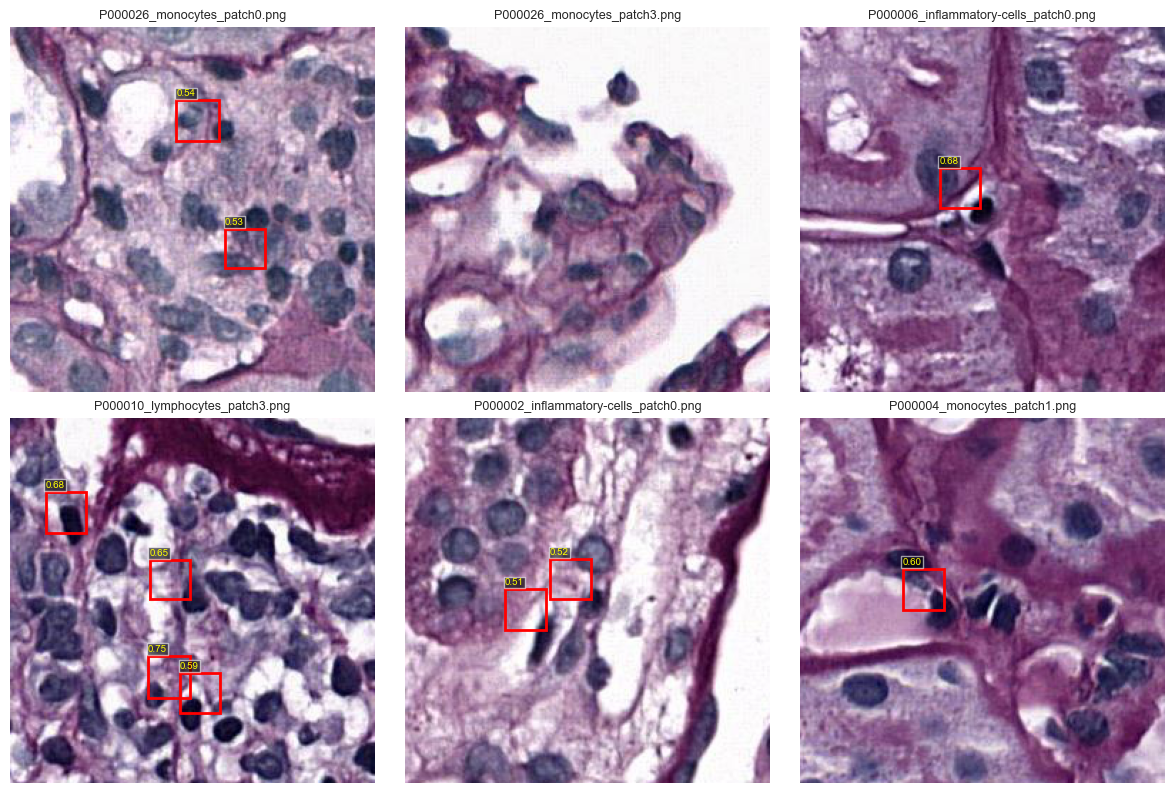

In [25]:
from pathlib import Path

PATCHES_DIR   = Path(r"C:\Users\lisan\AIMI_PROJECT\patches\cpg")
CLASS_FOLDERS = ["inflammatory-cells", "monocytes", "lymphocytes"]

# pick 6 radndom patches you want to inspect
to_plot = [
    "P000026_monocytes_patch0.png",
    "P000026_monocytes_patch3.png",
    "P000006_inflammatory-cells_patch0.png",
    "P000010_lymphocytes_patch3.png",
    "P000002_inflammatory-cells_patch0.png",
    "P000004_monocytes_patch1.png",
]

visualize_patch_grid(
    results,
    PATCHES_DIR,
    CLASS_FOLDERS,
    patch_list=to_plot,
    cols=3,
    figsize=(12, 8),
    score_thresh=0.5
)
